# Maximum Likelihood Estimation

Maximum Likelihood Estimation is a method of calculating the latent parameter/s of a model given a set of observations.

It is so called as it attempts to find the parameter values that are most likely to have produced the observed data—maximises the likelihood function.

The technique may be used in practice when it is infeasible to observe every member of a population and thus parameter estimates from a sample must be made.

## Formulation

Given a set of n i.i.d observations $x_1, x_2,......x_n$ which share a common distribution $p(\cdot|\theta)$ where theta is a vector of parameters for this family. Our goal is to find an estimator $\hat\theta$ that best describes true value of $\theta$.

We may reformulate this problem by specifying the joint density of all the observations.

This is given as $ p(x_1|\theta) \times p(x_2|\theta) ... \times p(x_n|\theta) = p(x_1,x_2,...,x_n|\theta)$ which in turn decomposes to  $\prod_{i=1}^n p(x_i | \theta)$

We now need to find theta. Maximum likelihood seeks the find value of theta that maximizes the probability of our joint probability function $p(x_1,x_2,...,x_n|\theta)$. The problem can in fact be rephrased as finding the value of $\theta$ that most likely given the observed data, which can be expressed mathematically as $L = (\theta | x_1,x_2,...,x_n)$.

The likelihood function is maximised when $$\nabla \prod_{i=1}^n p(x_i | \theta) = 0$$

In practice the calculation of the equation above can be difficult and itit is often easier to work with the natural logarithm of the likelihood. We can use the fact that the natural log is monotonically increasing $\mathbb R_+$ and that $$ ln(\prod_{i=1}^n p(x_i | \theta)) = \sum_{i=1}^n ln(p(x_i | \theta)) $$

Consequently, changing the logarithm doesn't change the location of maxima or minima.

More concretely, the method of maximum likelihood estimation finds the parameter vector $\hat\theta$ that maximises the log-likelihood of the data.

If we're lucky then $\hat\theta$ may be found analytically but very often it must be done numerically.

# Code Example

In [101]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Let's use the technique to described above to find the parameter estimates for a distribution on some real data.

The dataset we'll use will be the results from the English Premier League in the 2013-2014 season. We'll aim to fit a distribution to the total number of goals scored in per game.

In [221]:
# Load Data and create column for total goals scored
goal_data = pd.read_csv("13_14_Eng.csv")[["HomeTeam","AwayTeam","FTHG","FTAG"]]
goal_data["Total"] = goal_data.FTHG + goal_data.FTAG
goal_data.head()

,HomeTeam,AwayTeam,FTHG,FTAG,Total
0,Arsenal,Aston Villa,1,3,4
1,Liverpool,Stoke,1,0,1
2,Norwich,Everton,2,2,4
3,Sunderland,Fulham,0,1,1
4,Swansea,Man United,1,4,5


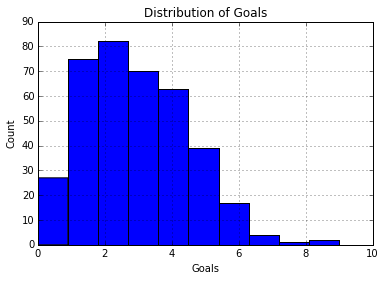

In [222]:
goal_data["Total"].hist()
plt.title("Distribution of Goals")
plt.xlabel("Goals")
plt.ylabel("Count")

Given the nature of the data— non-negative, discrete and right skewed— a Poisson distribution seems like a reasonable assumpition for this data.

If we were being more thorough we could test to see if the distributional assumptions of the Poission (e.g. Mean being equal to the Variance) are met. However for a first pass the Poisson assumption seems reasonable and whilst there exists a closed-form analytic solution for this problem let's proceed to solve it numerically.

The probability of observing the value $x$ on a datapoint drawn from a Poisson distribution is given by $$ P(x| \theta) = \frac{e^{-\theta}\theta^x}{x!} $$

The likelihood of $\theta$ can then be given as $$ L(\theta | x) = \prod_{i=1}^n \frac{e^{-\theta}\theta^{x_i}}{x_i!} = e^{-n\theta} \theta^{\sum_{i=1}^n x_i} \times \frac{1}{\prod_{i=1}^n x_i!}$$ and therefore the log-likelihood $l$ is given by $$ l(\theta | x) = -n\theta +  \sum_{i=1}^n x_i log \theta - \sum_{i=1}^n log(x_i!) $$

Let's define a python function that calculates the log-likelihood of a set of Poisson observations.

In [226]:
#Function that allows us to apply a factorial numpys factorial function to a vector.
def f(x):
    return np.math.factorial(x)

factorial = np.vectorize(f)

#function representing the negative of the log-likehood of the poisson distribution.
log_likelihood = lambda theta,x: len(x)*theta - np.sum(x)*np.log(theta) + np.sum(np.log(factorial(x)))

We'll find the value of theta that minimises the negative of our objective function. This is equivalent to maximising the original positive log-likelihood.

For the purpose of this analysis, we'll make use of the minimize function in scipy's optimize module and the BFGS (Broyden–Fletcher–Goldfarb–Shanno) algorithm. BFGS and other gradient based algorithms start with an arbitrary solution to a problem, then attempt to find a better solution by iteravtively changing the solution. If the change produces a better solution, an incremental change is made to the new solution.

In [230]:
lik_model = minimize(log_likelihood, np.array([3]),(goal_data.Total.values), method='L-BFGS-B')

theta = lik_model["x"][0]

print "The maximum likelihood estimate of theta given our data is: {0}".format(theta)

The maximum likelihood estimate of theta given our data is: 2.76842080226


We can test the validity of the Poisson distribution in modelling this data by overlaying a histogram of our observed data with a poisson distribution with it's mean parameter set to our estimated theta.

As shown in the plot below 

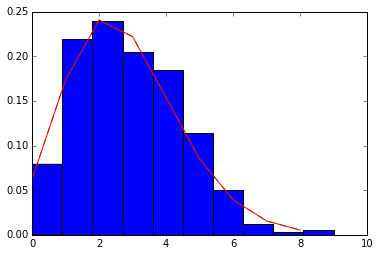

In [241]:
goals = goal_data.Total
goals.hist(normed=True, bins=10, grid=False)
x = range(goals.max())
plt.plot(x, poisson.pmf(x, theta), 'g--')
plt.plot(x, poisson.pmf(x, goals.mean()), 'r-')